# Lesson 4: CNN Review and Collaborative Filtering

In this lesson, we end our discussion of CNN's with a review of the convolutional, max pooling, and dense layers. We will then cover dynamic learning rates before introducing collaborative filtering and recommender systems.

## Reviewing Layers of a CNN

![img](https://i.imgur.com/OGckuIn.png[/img])

We'll start by revisiting the VGG16 model, which only has one type of convolutional and fully connected block (summarized in the image above, taken from [A Beginner's Guide to Understanding Convolutional Neural Networks](https://adeshpande3.github.io/adeshpande3.github.io/A-Beginner's-Guide-To-Understanding-Convolutional-Neural-Networks/)). Remember, the convolutional block is defined as:

```python
def ConvBlock(layers, model, filters):
    for i in range(layers): 
        model.add(ZeroPadding2D((1,1)))
        model.add(Convolution2D(filters, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
```

where each block is a convolutional layer stacked with an activation function and followed by a max pooling layer. The convolutional layer, ```Convolution2D```, passes filters over an input to produce different activation features. 

We first choose the number of filters we want to use and their dimensions (most convolutions use 3x3 filters). These filters are then passed over the input image to produce "simpler" images with different activation features using non-linear activation functions (in this case, ReLU) to reduce the possibility of overfitting our data. At the next convolutional layer, the filter dimensions are updated to be 3x3x$n$, where $n$ is the number of filters used in the previous layer. We then move on to the max pooling layer, ```MaxPooling2D```, which decreases the resolution of our input image by finding the max value of each 2x2 block.  

The max pooling layer is followed by a dense (or fully connected) layer, used to get as close to our expected output as possible, and another non-linear activation function (```relu```). The fully connected block is defined below:

```python
def FCBlock(model):
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))
```

So far, mathematically, dense and convolutional layers are relatively simple as they only involve matrix multiplication. The slight complication arises when weights are optimized through back propagation and the partial derivative of the loss function with respect to each weight. In this way, we're able to train really powerful models. 

## Reviewing SGD

Let's use the SGD algorithm on a simple linear function. We use $n$ random numbers in an array $x$ to form the line $y = ax + b$, where $a$ and $b$ are constants. Of course, our inputs $x$ and $y$ share the same dimensions because they are linearly related. In Keras, we start with our initial guesses of constants $a$ and $b$: $a_{guess}$ and $b_{guess}$. Given $x$, we use these values to calculate $y_{pred}$ before taking the sum of squared errors, ```sse```, of the generated output with the expected output, $y$.

In [1]:
def lin(a,b,x): return a*x+b
def sse(y,y_pred): return ((y-y_pred)**2).sum()
def loss(y,a,b,x): return sse(y, lin(a,b,x))
def avg_loss(y,a,b,x): return np.sqrt(loss(y,a,b,x)/n)

In [2]:
%matplotlib inline
import math,sys,os,numpy as np
from numpy.random import random
from matplotlib import pyplot as plt
from __future__ import print_function, division

In [3]:
def lin(a,b,x): return a*x+b
a = 3.; b = 8.; n = 30
x = random(n)
y = lin(a,b,x)
def sse(y,y_pred): return ((y-y_pred)**2).sum()
def loss(y,a,b,x): return sse(y, lin(a,b,x))
def avg_loss(y,a,b,x): return np.sqrt(loss(y,a,b,x)/n)
a_guess = -1.; b_guess = 1.
avg_loss(y, a_guess, b_guess, x)
lr = 0.12

Once we've calculated $y_{pred}$, we take the partial derivative of the loss function with respect to both $a_{guess}$ and $b_{guess}$ in order to update their values in the direction opposite the gradient at a specified rate. As mentioned in previous lessons, our libraries handle these derivatives for us analytically, not through finite differencing, by adding a learning rate to each of our inputs to see how the output varies. 

In [4]:
def upd():
    global a_guess, b_guess
    y_pred = lin(a_guess, b_guess, x)
    dydb = 2 * (y_pred - y)
    dyda = x*dydb
    a_guess -= lr*dyda.mean()
    b_guess -= lr*dydb.mean()

The updated parameters (or weights) are used for the next $x$ and $y$ values in the line. One pass through the entire line is one epoch and the more epochs we run, the closer $y_{pred}$ gets to $y$ and, consequently, the lower our calculated loss will be. However, with a small learning rate, this could take a while. Slightly increasing the steps we take opposite the gradient will help minimize our loss faster. Be careful though, because a large learning rate could cause divergence. The graph below shows $y_{pred}$ after 10 updates (epochs) with a learning rate of 0.12.

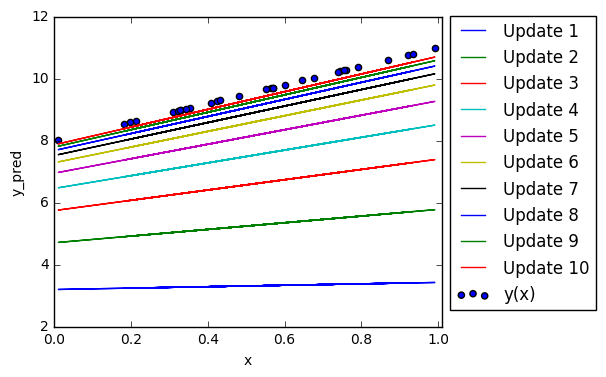

In [5]:
fig = plt.figure(dpi=100, figsize=(5, 4))
plt.scatter(x,y, label = "y(x)")
plt.axis([0, 1.01, 2, 12])
plt.xlabel("x")
plt.ylabel("y_pred")
for i in range(10): 
    upd()
    line, = plt.plot(x,lin(a_guess,b_guess,x), label = "Update " + str(i+1))
plt.legend(bbox_to_anchor=(1.42, 1.03))

To increase the training speed while also minimizing the risk of divergence, we use a **momentum parameter**. 

## Momentum

Setting high learning rates could result in overshooting one iteration and undershooting the next, getting into an oscillating pattern where training never converges. **Momentum** is meant to reduce the risk of this oscillation while also increasing the training speed. How does this work? Well, as we near the global minimum of our loss function, we continually decrease our momentum parameter. In this way, momentum is a technique that uses an adaptive learning rate that varies based on the weights used.

To apply momentum to our update function, we add the average from the previous gradient to the gradient term. So, when we think of the hypersurface of our loss function, which has saddle points--points where the gradient is really low but doesn't reach a minima, taking the average of the previous gradient will help us avoid bouncing between saddle points. Instead, the average goes along the trough of the function. 

## Dynamic Learning Rates

Momentum, while effective for certain parameters, doesn't effectiently optimize all parameters. A better approach is to dynamically adjust the learning rate for each parameter, using what was learned from the optimization process.

### Adagrad

**Adagrad (Adaptive Gradient Algorithm)** is a technique where the learning rate is adjusted for each individual parameter based on the previous gradients for that parameter. Specifically, we take the squares of the gradient from the previously calculated parameter (to focus on magnitude, not whether the number is positive or negative) and square root the sum (otherwise known as the **l2-norm**). For the next epoch, the new learning rate becomes the overall learning rate divided by the l2-norm of the previous update. So, if the l2-norm is large, the learning rate will be small and vice versa. Applying this to our line $y = mx + b$, the learning rate becomes:

$$lr = \frac{lr}{\frac{dl}{da} + \frac{dl}{db}}$$ 

where $\frac{dl}{da}$ and $\frac{dl}{db}$ are the partial derivatives of the loss with respect to constants $a$ and $b$.

When using adagrad and other forms of dynamic learning rates, it's good practice to intially set ```lr``` higher since it will eventually decrease when divided by the sum of the derivatives. This is one of adagrad's primary limitations: continually shrinking the learning rate for a given parameter, eventually stopping training on that parameter at some point. 

### RMSProp

**RMSProp (Root Mean Square Propagation)** is very similar to adagrad, but resolves its limitation by being able to both decrease and increase the learning rate. Like adagrad, the overall learning rate is divided by the square root of the sum of squares of the previous update gradients for a given parameter. However, RMSProp doesn’t keep track of the weighted running average of the gradients equally. Instead, it uses an exponentially weighted moving average of the previous update gradients during one epoch. So, older values contribute less than newer ones, allowing parameters to jump around the optimum without moving too far out from the minima. 

### Adam

**Adam (Adaptive Moment Estimation)** combines the benefits of momentum with those of RMSProp. Momentum is able to learn from the moving average of the gradient and continues to adjust parameters in that direction. RMSProp learns from the weighted moving average of the square of the gradients, proportionally shrinking the learning rate. Adam incorporates both of these benefits by multiplying the learning rate with the momentum and dividing by a factor related to the variance.

### Eve

**Eve** is an extension of Adam that keeps track of the change in loss function and updates the learning rate with the difference. Essentially, Eve increases the learning rate when there is little to no change in the loss function, and decreases it when the loss function fluctuates. So, when the loss function is barely changing, increasing the learning rate will effectively increase the training speed and vice versa. One of Eve's limitations comes when approaching a minimum. We want to take small steps to near our minimum, but Eve takes the small change in gradient as an incentive to increase the learning rate, which will bounce us out of our minimum. 

## State Farm Kaggle Competition

In this lesson, we covered Jeremy's approach to the State Farm Kaggle Competition, where we used **semi-supervised learning** to learn from unlabeled data. This was helpful to use for the competition since our given test set (unlabeled) contained 80,000 images whereas the training set (labeled) only had 20,000. 

The details on this submission can be found in my [State Farm Competition notebook](https://github.com/fdaham/fastai/blob/master/state-farm-kaggle.ipynb).


## Collaborative Filtering

We'll now move on from CNNs to deep learning in **Natural Language Processing (NLP)**. The path to NLP starts with **collaborative filtering**, which is a method used by **recommender systems** to make predictions on user interests from information collected from the user. 

### Recommender Systems

Recommender systems are essentially information filtering systems that predict user ratings, taste, and preferences. One of the main ways to build a recommender system is to use collaborative filtering. In a movie recommender system, collaborative filtering will predict your rating of a movie by finding users that have rated the same movies as you have. 

The dataset we'll be using to better understand collaborative filtering is the [Movielens Dataset](https://grouplens.org/datasets/movielens/), which contains user ratings for different movies. For this example, we only focus on the top fifteen users and movies. Their ratings can be seen below:

![img](http://i.imgur.com/EJkOtqD.png[/img])

To make learned predictions from our data set, we use **embeddings** for each movie and user. Embeddings are vectors used to describe qualities or features of our data. Taking the dot product of each user/movie embedding pair for the user's movie rating allows us to train the elements of each embedding as parameters during gradient descent. 

![img](http://i.imgur.com/ORN4McB.png[/img])

In our example, we've created embeddings with five elements, or **latent factors**. We rarely know exactly what attributes these factors are for. All we know is that, through gradient descent, these learned factors better predict user ratings. We can train a neural network by concatenating the latent factor embeddings and applying them to our known ratings.

Now, how do we account for user/movie **bias**? For example, what if a movie is more popular than the others and recieves more/higher ratings? We account for this in our collaborative filtering process by adding bias terms to each user and movie embedding. These terms are treated as parameters in training and optimized during gradient descent.